### `Importing Libraries`

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from imblearn.over_sampling import SMOTE

### `Loading the dataset: German Credit Risk  Dataset` 

In [ ]:
# Loading the dataset
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                   header=None, sep=' ')

In [ ]:
# Define feature names
feature_names = ['status', 'duration', 'credit_history', 'purpose', 'amount',
                 'savings', 'employment_duration', 'installment_rate', 'statussex',
                 'other_debtors', 'residence_since', 'property', 'age', 'other_installment_plans',
                 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker',
                 'labels']

In [ ]:
# Assign the feature names to the dataset
data.columns = feature_names

> Attributes description



---

```
- Status of existing checking account, in Deutsche Mark.
- Duration in months
- Credit history (credits taken, paid back duly, delays, critical accounts)
- Purpose of the credit (car, television et al)
- Credit amount
- Status of savings account/bonds, in Deutsche Mark.
- Present employment, in number of years.
- Installment rate in percentage of disposable income
- Personal status (married, single,…) and sex
- Other debtors / guarantors
- Present residence since X years
- Property (e.g. real estate)
- Age in years
- Other installment plans (banks, stores)
- Housing (rent, own et al)
- Number of existing credits at this bank
- Job
- Number of people being liable to provide maintenance for
- Telephone (yes, no)
- Foreign worker (yes, no)
```

In [ ]:
data.head()

status  duration credit_history purpose  amount savings employment_duration  \
0    A11         6            A34     A43    1169     A65                 A75   
1    A12        48            A32     A43    5951     A61                 A73   
2    A14        12            A34     A46    2096     A61                 A74   
3    A11        42            A32     A42    7882     A61                 A74   
4    A11        24            A33     A40    4870     A61                 A73   

   installment_rate statussex other_debtors  ...  property age  \
0                 4       A93          A101  ...      A121  67   
1                 2       A92          A101  ...      A121  22   
2                 2       A93          A101  ...      A121  49   
3                 2       A93          A103  ...      A122  45   
4                 3       A93          A101  ...      A124  53   

   other_installment_plans housing number_credits   job people_liable  \
0                     A143    A152              2  A173             1   
1                     A143    A152              1  A173             1   
2                     A143    A152              1  A172             2   
3                     A143    A153              1  A173             2   
4                     A143    A153              2  A173             2   

   telephone foreign_worker labels  
0       A192           A201      1  
1       A191           A201      2  
2       A191           A201      1  
3       A191           A201      1  
4       A191           A201      2  

[5 rows x 21 columns]

### `Preprocessing the dataset : Data Aug, Feature Selection/Importance`

In [ ]:
# Convert categorical variables to numerical using one-hot encoding
categorical_cols = ['status', 'credit_history', 'purpose', 'savings', 'employment_duration',
                    'statussex', 'other_debtors', 'property', 'other_installment_plans',
                    'housing', 'job', 'telephone', 'foreign_worker']
data = pd.get_dummies(data, columns=categorical_cols)

In [ ]:
# labels: class 1(good credit)", "class 0(bad credit)
data.labels.replace([1,2], [1,0], inplace=True)

In [ ]:
# Define the target variable and the features
target_col = 'labels'

features = data.drop(target_col, axis=1)

target = data[target_col]

sensitive_features = ['statussex', 'age']

### `Strategy 1: Applying data augmentation technique`

In [ ]:
# Apply SMOTE : Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in your dataset in a balanced way.
sm = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = sm.fit_resample(features , target)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
print("Before applying SMOTE technique \n")

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print("\n After applying SMOTE technique \n")

unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

Before applying SMOTE technique 

{0: 569, 1: 551}

 After applying SMOTE technique 

{0: 700, 1: 700}


### `Training the XGBoost Model`

In [ ]:
# Define the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'seed': 42
}

# Train the XGBoost classifier
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### `Testing the XGBoost Model`

In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

### `Evaluating the model`

In [ ]:
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       131
           1       0.84      0.86      0.85       149

    accuracy                           0.84       280
   macro avg       0.84      0.83      0.83       280
weighted avg       0.84      0.84      0.84       280



In [ ]:
print("Accuracy of the model is: ", round(accuracy_score(y_test, y_pred), 2)*100,"%")

Accuracy of the model is:  84.0 %


### `Applying fairness technique`

In [ ]:
from sklearn.metrics import confusion_matrix

# TPR = True positive rate : a metric that measures the percentage of actual positives that are accurately identified.
def true_positive_rate(y_true, y_pred, sensitive_features, group):
    # Filter the instances belonging to the specified group
    group_indices = (sensitive_features == group)

    # Calculate the true positives (TP)
    tp = sum((y_true == 1) & (y_pred == 1) & group_indices)

    # Calculate the total positives (TP + FN) for the specified group
    total_positives = sum((y_true == 1) & group_indices)

    # Calculate the TPR for the specified group
    tpr = tp / total_positives if total_positives > 0 else 0

    return tpr

# Calculate the Equal Opportunity Difference
def equal_opportunity_difference(y_true, y_pred, sensitive_features, privileged_group, unprivileged_group):
    tpr_privileged = true_positive_rate(y_true, y_pred, sensitive_features, privileged_group)
    tpr_unprivileged = true_positive_rate(y_true, y_pred, sensitive_features, unprivileged_group)
    
    eod = tpr_privileged - tpr_unprivileged
    
    return eod


# Convert the sensitive features to a DataFrame
sensitive_data = pd.DataFrame(sensitive_features, columns=['statussex'])

# Combine the true labels and sensitive features into a single DataFrame
evaluation_data = pd.concat([y_test.reset_index(drop=True), sensitive_data.reset_index(drop=True)], axis=1)

# Group the evaluation data by the sensitive attribute
grouped_data = evaluation_data.groupby('statussex')

# Calculate Equal Opportunity Difference for each group
eod = equal_opportunity_difference(evaluation_data['labels'], y_pred, grouped_data, 1, 0)

# Print results
print("Equal Opportunity Difference:")
print(eod)



Equal Opportunity Difference:
0


#### `In terms of fairness, achieving an Equal Opportunity Difference of zero is often considered desirable as it indicates that the model is providing fair treatment in terms of positive predictions across different groups. It suggests that the model's performance in identifying positive instances (e.g., detecting the positive outcome of a specific class) is consistent for both the privileged and unprivileged groups, without favoring one group over the other.`

In [ ]:
# Get the predicted labels for the privileged and unprivileged groups
privileged = y_pred[(X_test['statussex_A91'] == 1) | (X_test['statussex_A93'] == 1) | (X_test['statussex_A94'] == 1) & (X_test['age'] > 18)]
unprivileged = y_pred[(X_test['statussex_A92'] == 1) & (X_test['age'] > 18)]

# Calculate the proportions of positive predictions for each group
privileged_proportion = np.mean(privileged)
unprivileged_proportion = np.mean(unprivileged)

# Calculate the Statistical Parity Difference
statistical_parity_difference = privileged_proportion - unprivileged_proportion

# Print the Statistical Parity Difference
print(f"Statistical Parity Difference: {statistical_parity_difference:.4f}")


Statistical Parity Difference: 0.2017


### `Explanability of model and predictions`

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 13.8 MB/s eta 0:00:00


### `SHAP and LIME techniques`

---


```
SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) are two popular techniques for explaining the predictions of machine learning models.

SHAP values provide an explanation of the contribution of each feature to a specific prediction.  
Positive SHAP values indicate that the feature positively contributes to the prediction, while negative values indicate a negative contribution. The magnitude of the SHAP value represents the strength of the contribution.

LIME, on the other hand, focuses on explaining individual predictions. It approximates the behavior of a complex model by creating a local, interpretable model around the prediction of interest. 

LIME generates a set of local perturbations to the input and observes how the model predictions change. It then assigns importance weights to the features based on their impact on the local model's predictions.


The choice between SHAP and LIME depends on the specific requirements of the use case and the level of interpretability desired.

```



In [ ]:
import shap

# Create an explainer object using the XGBoost model and the training data
explainer = shap.Explainer(clf, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)


 93%|=================== | 261/280 [00:13<00:00]       

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


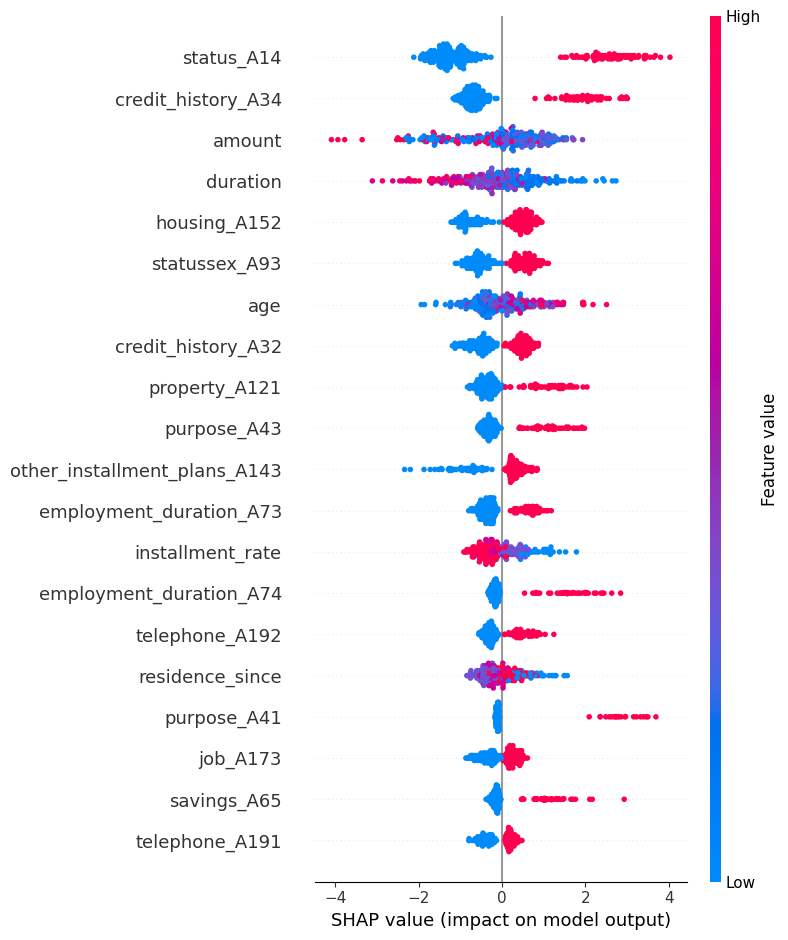

In [ ]:
# Summarize the SHAP values
shap.summary_plot(shap_values, X_test)


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=64235d31fc4fabcb86c9a3ecfcd92bc9591d8b71337940b7be5b2fce2614e68f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

# Create an explainer object using the XGBoost model and the feature names
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)

# Select a specific instance for explanation
instance_idx = 5
instance = X_test.iloc[instance_idx]

# Generate LIME explanation for the selected instance
explanation = explainer.explain_instance(instance.values, clf.predict_proba, num_features=len(X_train.columns))

# Print the explanation
explanation.show_in_notebook()


#### `Below LIME explanation for a specific instance, shows the contribution of each feature towards the predicted probability.`

In [ ]:
import lime
import lime.lime_tabular

# Create an explainer object using the XGBoost model and the feature names
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)

# Select a specific instance for explanation
instance_idx = 10
instance = X_test.iloc[instance_idx]

# Generate LIME explanation for the selected instance
explanation = explainer.explain_instance(instance.values, clf.predict_proba, num_features=len(X_train.columns))

# Print the explanation
explanation.show_in_notebook()


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from lime.lime_text import LimeTextExplainer
import shap

# Sample training data
texts = [ "I love the beaches here at Malaga!!", "This movie is terrible", "The sounds so exciting!", "The plot was not good", "We have so many attendees, be it developers, CEO's, datascientists, researchers at the J On The Beach Conference!"]
labels = [1, 0, 1, 0, 1]

# Vectorize the text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# Train a logistic regression classifier
model = make_pipeline(vectorizer, LogisticRegression())
model.fit(texts, labels)

# Text to explain
text_to_explain = "So exciting to be presenting  at the J On The Beach conference, at Malaga!!"
#text_to_explain = "I do not like this movie"

# LIME explanation
explainer = LimeTextExplainer(class_names=["Negative", "Positive"])
exp = explainer.explain_instance(text_to_explain, model.predict_proba, num_features=5)
exp.show_in_notebook(text=True)

